# Machine Vision - Exercise 3

<!--
Automation and Control Institute - TU Wien
Matthias Hirschmanner 2023
machinevision@acin.tuwien.ac.at
 -->

In this exercise you will implement a neural network to classify images of the CIFAR10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). It consists of 60000 images with a resolution of 32x32. The different classes and example images for each classes are shown in Figure 1 below. We will use the library PyTorch to create and train neural networks.


![Classes of CIFAR10](https://owncloud.tuwien.ac.at/index.php/apps/files_sharing/ajax/publicpreview.php?x=1064&y=425&a=true&file=ex4_cifar10_2.png&t=PfJAai8huq9AWRa)

Figure 1: Examples of the different classes of the CIFAR10 dataset.

---



Please keep the code in the sections below clean and only change it in the dedicated areas. You shouldn't need to change it anywhere else. You also shouldn't need to use any additional libraries other than the ones already imported. If you need to change the code somewhere else or need to import a different library to get a functioning program, that might be a bug. Please report it in the Tuwel forum or send us a mail to machinevision@acin.tuwien.ac.at


## Import Libraries
In a first step we import the libraries needed for the exercise. Please execute the cell below.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random
import requests
import imageio
from PIL import Image
from typing import List

import torch
import torchvision
import torchvision.transforms as transforms


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import os
from typing import Tuple

os.environ['KMP_DUPLICATE_LIB_OK']='True'
get_ipython().__class__.__name__ = "ZMQInteractiveShell"

print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
if torch.cuda.is_available():
    print('Device:', torch.cuda.get_device_name(0))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))


Torch 2.1.0+cu118 CUDA 11.8
Device: Tesla T4
Using cuda device


After executing this cell, it should show that you are using a "cuda" device. This means you can run code on the GPU. If this is not the case, change the runtime to GPU.

**Since Google Colab seems to be a bit more restrictive with the GPU than in previous years, I recommend to do the first parts of the exercise only with CPU and switch to GPU once you train your CNN model (7. Convolutional Neural Network).**

## PyTorch
The first step of the exercise is mainly aimed at getting familiar with the PyTorch library and how it works. We will use it to define and train neural networks. The main data structure of PyTorch are tensors. They are very similar to NumPy arrays, but can run on GPUs or other hardware accelerators. Tensors are optimized for automatic differentiation which we will use for gradient descent to optimize the parameters/weights of an network.

In [2]:
# Demo of creating a tensor from a numpy array and then moving it to the GPU.
a_np = np.array([[1,2],[3,4]])
print(a_np)
a_t = torch.from_numpy(a_np)
print(a_t)
a_t_gpu = a_t.to(device)
print(a_t_gpu)

b_np = np.array([[1,2],[3,4]])
b_t = torch.from_numpy(a_np)

# This would not work, because b_t is on the CPU and a_t on the GPU
# print(b_t*a_t_gpu)

print(b_t.to(device)*a_t_gpu)

[[1 2]
 [3 4]]
tensor([[1, 2],
        [3, 4]])
tensor([[1, 2],
        [3, 4]], device='cuda:0')
tensor([[ 1,  4],
        [ 9, 16]], device='cuda:0')


When we apply functions on our tensors, PyTorch (or more specifically autograd) keeps a record of all tensors, operations and resulting new tensors in a directed acyclic graph (DAG) also called the Computational Graph. It also supports automatically calculating the gradients of all tensors using backpropagation (which is the fancy term to apply the chain rule). For an introduction to these computational graphs and how to calculate gradients, see https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html. For a good introduction to backpropagation, you can watch this video which is also linked in the tutorial above: https://youtu.be/tIeHLnjs5U8

##1. Linear Regression and Gradient Descent (3 Points)
As a first step to get to know PyTorch and using its automatic differentiation engine, you will implement linear regression with a neural network. Linear regression refers to the method of fitting a linear model to approximate some input data. In other words, we want to find the coefficients of a function $w_1x_1+w_2x_2+\dots +w_nx_n+b=y$ to minimize the distance of our input data to the estimated values. There are many methods that are better suited to solve this problem, e.g. Least Squares or RANSAC (which we will implement in exercise 5). However, to get familiar with neural networks, we will solve this task with a 1 layer neural network and Gradient Descent. The network is shown in Figure 2.

Implement the function `linear_regression` which takes as input the array $\mathbf{X}$ and vector $\mathbf{y}$ and returns the coefficients of the linear model $(w_1,w_2,\dots,w_n,b)^T$. You should perform gradient descent to minimize the loss function to estimate these coefficients. As a loss function, use the (mean) squared distance. You should use tensors and the PyTorch's autograd engine. Do not use a built-in optimizer, but implement a simple gradient descent yourself.

Tipp: When updating the weights/coefficients use `with torch.no_grad():`, otherwise PyTorch will also keep track of these functions and its gradients. After updating the weights with the gradients, set them to 0, otherwise PyTorch adds up future gradients.

![Linear Model](https://owncloud.tuwien.ac.at/index.php/apps/files_sharing/ajax/publicpreview.php?x=1023&y=400&a=true&file=ex4_linearmodel.png&t=A4cyYi3Lgrp1MXM&scalingup=0)

Figure 2: Linear model visualized as a one layer neural network.

---

In [3]:
def linear_regression(x_in: np.ndarray,
                      y_in: np.ndarray,
                      learning_rate: float = 0.01,
                      epochs: int = 30) -> Tuple[np.ndarray, np.ndarray]:
  """ Calculate the coefficients of the linear model w1x1+w2x2+...+wnxn+b = y
      to fit the input data using gradient descent.

  :param x_in: The independent variables x. Each row is related to one datapoint.
  :type x_in: np.ndarray with shape (data_points, nr. of independent variables)

  :param y_in: The dependent variable y. Each row is related to one datapoint.
  :type y_in: np.ndarray with shape (data_points, 1)

  :param learning_rate: The coefficient to update the weights per gradient
    descent iteration.
  :type learning_rate: float in (0,1)

  :param epochs: Number of times the whole dataset is used for gradient descent-
  :type epochs: int > 0

  :return: (coefficients, loss_history)
    coefficients: The coefficients of the linear model (w1,w2,...,wn,b)
    loss_history: Array with the mean squared loss per epoch.
  :rtype:
    coefficients: np.ndarray (w1,w2,...,wn,b) with shape (nr. of ind. variables + 1,)
    loss_history: np.ndarray (loss_ep1, loss_ep2, ... loss_epn) with shape (epoch,)
  """
  ###################################
  # Initialize coefficients with zeros for weights and bias
  coefficients = np.zeros(x_in.shape[1] + 1)

  # Initialize an array to record the loss at each epoch
  losses = np.zeros(epochs)

  # Add a column of ones to x_in for the bias term
  x_with_bias = np.hstack((x_in, np.ones((x_in.shape[0], 1))))

  for epoch in range(epochs):
        # Predictions for current coefficients
        predictions = x_with_bias.dot(coefficients)

        # Calculate the error
        errors = predictions - y_in.squeeze()

        # Mean Squared Error (MSE)
        loss = np.mean(errors ** 2)
        losses[epoch] = loss

        # Gradient for MSE
        gradients = 2 * x_with_bias.T.dot(errors) / x_in.shape[0]

        # Update the coefficients
        coefficients -= learning_rate * gradients


  ###################################
  return coefficients, losses

Below we apply your linear regression algorithm. You might need to change the learning rate or the number of epochs to get good results, depending on the details of your implementation.

<Figure size 640x480 with 0 Axes>

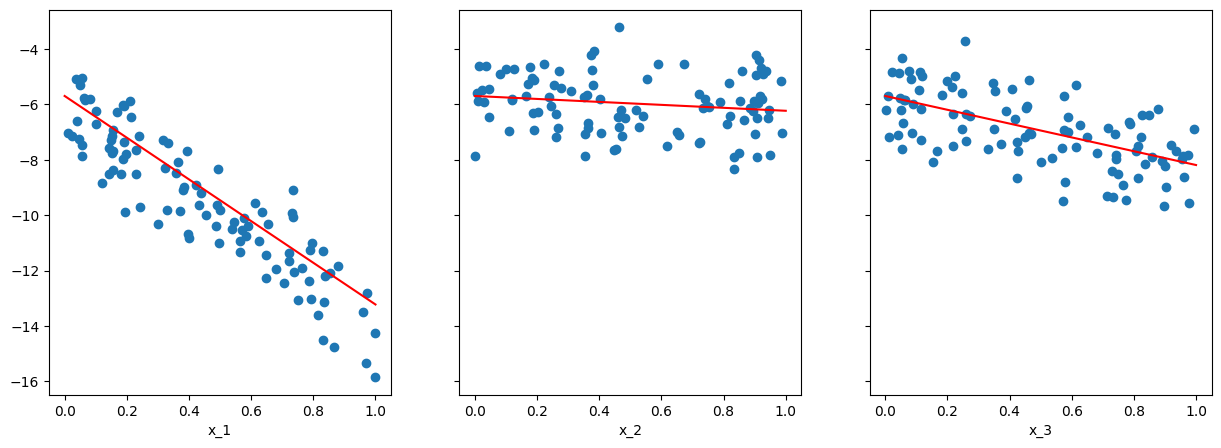

(100, 1)


In [4]:
# Adapt these parameters if necessary
learning_rate = 0.01
epochs = 2000

# Generate random data
x_in = np.random.rand(100, 3)

# Extend with ones to add the constant factor in one operation
x_in_homogeneous = np.c_[x_in, np.ones(100)]

# Generate random coefficients w1, w2, w3, b
coeff_in = np.random.randint(-10, 10, 4)

# Generate noise from a Normal Distribution.
# Might be helpful to repmove noise for debugging
noise = np.random.randn(100)

# Calculate y
y_in = np.dot(x_in_homogeneous, coeff_in) + noise
y_in = np.expand_dims(y_in, axis = 1)

# Apply linear regression
# Depending on your implementation, you might need to change your learning rate!
coefficients, losses = linear_regression(x_in,
                                         y_in,
                                         learning_rate = learning_rate,
                                         epochs = epochs)

# Plot the output per dimension
f = plt.figure()
f, axes = plt.subplots(nrows = 1,
                       ncols = x_in.shape[1],
                       sharex= True,
                       sharey = True,
                       figsize=(15,5))

t = np.array([0,1])


axes[0].scatter(x_in[:,0],
                x_in[:,0] * coeff_in[0] + coeff_in[3] + noise,
                marker = "o")
axes[0].plot(t, t * coefficients[0] + coefficients[3], color = 'red')
axes[0].set_xlabel('x_1')

axes[1].scatter(x_in[:,1],
                x_in[:,1] * coeff_in[1] + coeff_in[3] + noise,
                marker = "o")
axes[1].plot(t, t * coefficients[1] + coefficients[3], color = 'red')
axes[1].set_xlabel('x_2')

axes[2].scatter(x_in[:,2],
                x_in[:,2] * coeff_in[2] + coeff_in[3] + noise,
                marker = "o")
axes[2].plot(t, t * coefficients[2] + coefficients[3], color = 'red')
axes[2].set_xlabel('x_3')


plt.show()
print(y_in.shape)

## Load Dataset
In this exercise we will experiment with different neural networks to classify the images of the CIFAR10 dataset. First, we load the CIFAR10 dataset. The training images are in `trainset` and the test images in `testset`. We also create dataloaders for both sets. For more information how to use the datasets and dataloaders you can check https://pytorch.org/tutorials/beginner/basics/data_tutorial.html.


In [5]:
# Load datasets
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=128,
                                          shuffle=True,
                                          pin_memory = True,
                                          num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1024,
                                         shuffle=False,
                                         pin_memory = True,
                                         num_workers=2)

# The classes are:
# 0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
# 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'

100%|██████████| 170498071/170498071 [00:04<00:00, 41010840.07it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


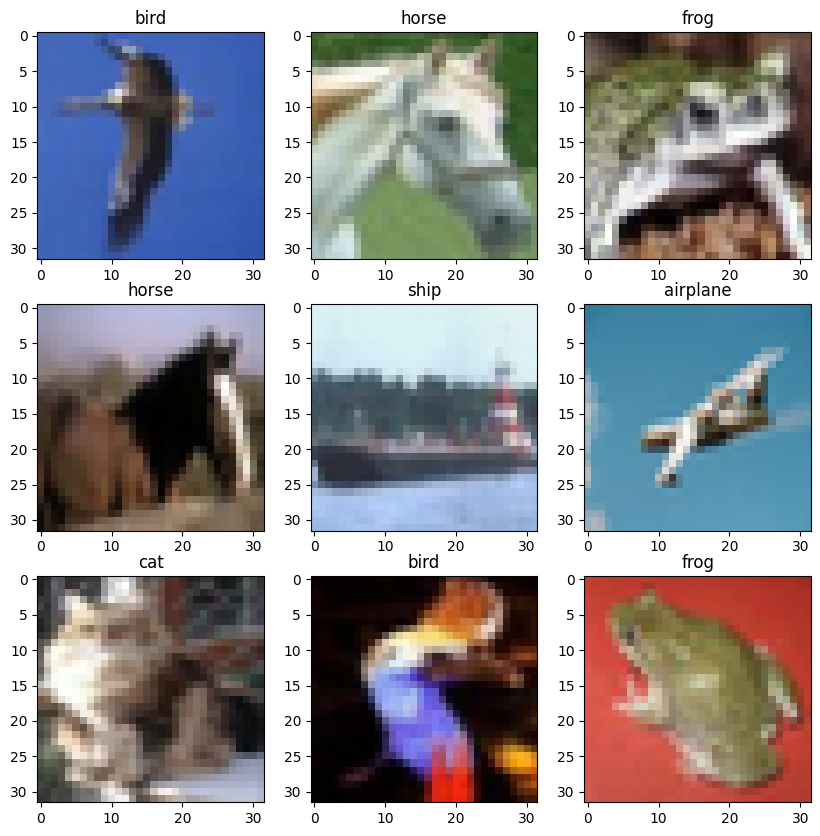

In [6]:
#@title Run this cell!
#@markdown It will show you 9 random images of the dataset.
#@markdown The code itself is not relevant, but it is important for later to execute this cell because some plotting functions are defined here.
fig, axs = plt.subplots(3, 3,figsize=(10,10))
labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
random_indices = np.random.randint(testset.data.shape[0], size=9)
for (idx,ax) in zip(random_indices,axs.flat):
  ax.set_title(labels[testset.targets[idx]])
  ax.imshow(testset.data[idx])


def plot_predictions(dataloader: torch.utils.data.DataLoader,
                     model_name: torch.nn.Module,
                     class_name: str = None,
                     sort_predictions: bool = False,
                     num_batches: int = np.inf):
    """ Plot the predictions for some random images. If class_name is set, it will be images of this class

    :param dataloader: The dataloader you want to to load the images
    :type dataloader: torch.utils.data.DataLoader

    :param model_name: Your PyTorch module you want to use to predict labels
    :type model_name: torch.nn.Module

    :param class_name: Define if you are interested in the predictions of one specific class, e.g. "dog"
    :type class_name: str

    :param sort_predictions: If True, plots the images with the highest prediction values. Otherwise random
    :type sort_predictions: bool

    :param num_batches: The number of batches we will load with the dataloader. Can help to reduce used memory.
    :type num_batches: int

    :return: None
    :rtype: None
    """

    if num_batches <= 0:
        raise ValueError("The argument num_batches has to be above 0")

    classes = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse',
               8: 'ship', 9: 'truck'}
    classes_inv = {v: k for k, v in classes.items()}

    if next(model_name.parameters()).is_cuda:
        device = 'cuda'
    else:
        device = 'cpu'

    # If the dataset involves some normalization, we need to "unnormalize" the
    # images again for plotting. There is probably a better solution for it.
    unnormalize = None
    if isinstance(dataloader.dataset.transform,
                  torchvision.transforms.transforms.Compose):
      for t in dataloader.dataset.transform.transforms:
        if isinstance(t, torchvision.transforms.transforms.Normalize):
          unnormalize = transforms.Normalize((-np.array(t.mean) / np.array(t.std)).tolist(), (1.0 / np.array(t.std)).tolist())

    if unnormalize:
      to_img_transform = transforms.Compose([unnormalize,
                                            transforms.ToPILImage()])
    else:
      to_img_transform = transforms.ToPILImage()

    # Set the model to eval() compared to train
    model_name.eval()

    # We go through our data and store it
    # (storing all the images can use a lot of memory, but should work fine for CIFAR10)
    y_predictions_tens = torch.empty([0, 10])
    y_true_tens = torch.empty([0, ])
    x_tens = None
    for batch_idx, (x, y) in enumerate(dataloader):
        with torch.no_grad():
            if batch_idx + 1 > num_batches:
                break
            pred = F.softmax(model_name(x.to(device)), dim=1)
            y_predictions_tens = torch.cat((y_predictions_tens, pred.cpu()))
            y_true_tens = torch.cat(((y_true_tens), y.cpu()))
            if not isinstance(x_tens, torch.Tensor):
              x_tens = x.clone()
            else:
              x_tens = torch.cat((x_tens, x))

    # Get the predicted labels for all images
    y_predictions_labels = y_predictions_tens.argmax(dim=1)

    # Get a boolean mask for all images that were correctly classified
    mask_true_predictions = (y_predictions_labels == y_true_tens)

    if class_name:
        class_number = classes_inv.get(class_name, -1)
        if class_number != -1:  # taking only predictions with defined class_name

            # Boolean Mask of images that were correctly predicted with class_name
            class_mask_correct = (y_true_tens[mask_true_predictions] == class_number)

            # Boolean Mask of images that are images of the class_name, but were wrongly predicted (false negatives)
            class_mask_false_negatives = (y_true_tens[~mask_true_predictions] == class_number)

            # Boolean Mask of images that were predicted as class_name, but are of a different class (false positives)
            class_mask_false_positives = (y_predictions_labels[~mask_true_predictions] == class_number)

            print('Number of correct recognized', class_name, 'images is', class_mask_correct.sum().numpy())
            print('Number of images recognized as', class_name, 'but are not of that class is',
                  class_mask_false_positives.sum().numpy())
            print('Number of images not recognized as', class_name, 'but actually are of that class is',
                  class_mask_false_negatives.sum().numpy())
        else:
            print('No such class like', class_name + '. Check class name again.')
    else:
        print('Number of correct recognized images:', mask_true_predictions.sum().numpy())
        print('Number of wrong recognized images:', (~mask_true_predictions).sum().numpy())

    images_per_row = 10  # Number of images we want to plot per row
    if class_name:
        if class_number != -1:
            fig = plt.figure(figsize=(20, 7.5))

            ######################################################################################################
            # First we want to plot images that were correctly classified

            # We sample indices of the images to plot.
            # If sort_predictions = True, we will plot the images with the highest prediction value
            if sort_predictions:
                idx_correct_sorted = y_predictions_tens[mask_true_predictions][class_mask_correct].max(
                    dim=1).values.argsort(descending=True)
                idx_correct = idx_correct_sorted[:images_per_row]

            # If sort_predictions = False, we sample random indices
            else:
                perm = torch.randperm(class_mask_correct.sum())
                idx_correct = perm[:images_per_row]

            # Apply our generated Boolean masks to get the sampled images that were correctly identified
            x_samples = x_tens[mask_true_predictions][class_mask_correct][idx_correct]

            # Get the predicted class number (if we did everything correct, it should only return class_number)
            y_samples = y_predictions_labels[mask_true_predictions][class_mask_correct][idx_correct]

            # Get the Softmax prediction values of the sampled images
            y_prediction_samples = y_predictions_tens[mask_true_predictions][class_mask_correct][idx_correct]

            # Get the max value of the prediction values
            # y_prediction_right_samples = y_prediction_samples[range(len(y_samples)), y_samples]
            y_prediction_samples_max = y_prediction_samples.max(dim=1).values

            # Plot it
            for idx in range(len(x_samples)):
                a = fig.add_subplot(3, 10, idx + 1)
                imgplot = plt.imshow(to_img_transform(x_samples[idx]))
                a.set_title(
                    classes[int(y_samples[idx])] + "\n p=" + str(y_prediction_samples_max[idx].numpy().round(4)),
                    color='green',
                    y=-0.35)
                a.axis('off')

            ######################################################################################################
            # Next, we want to plot false positives - Images that are classified as the specific class,
            # but actually belong to a different class.

            # We sample indices of the images to plot.
            # If sort_predictions = True, we will plot the images with the highest prediction value
            if sort_predictions:
                idx_false_positive_sorted = y_predictions_tens[~mask_true_predictions][
                    class_mask_false_positives].max(dim=1).values.argsort(descending=True)
                idx_false_positive = idx_false_positive_sorted[:images_per_row]

            # If sort_predictions = False, we sample random indices
            else:
                perm = torch.randperm(class_mask_false_positives.sum())
                idx_false_positive = perm[:images_per_row]

            # Apply our generated Boolean masks to get the sampled images that are false positives
            x_samples = x_tens[~mask_true_predictions][class_mask_false_positives][idx_false_positive]

            # Get the predicted class number (if we did everything correct, it should only return class_number)
            y_samples = y_predictions_labels[~mask_true_predictions][class_mask_false_positives][idx_false_positive]

            # Get the Softmax prediction values of the sampled images
            y_prediction_samples = y_predictions_tens[~mask_true_predictions][class_mask_false_positives][
                idx_false_positive]

            # Get the max value of the prediction values
            # y_prediction_samples_max = y_prediction_samples[range(len(y_samples)), y_samples] # Does the same
            y_prediction_samples_max = y_prediction_samples.max(dim=1).values

            # Plot it
            for idx in range(len(x_samples)):
                a = fig.add_subplot(3, 10, idx + images_per_row + 1)
                imgplot = plt.imshow(to_img_transform(x_samples[idx]))
                a.set_title(
                    classes[int(y_samples[idx])] + "\n p=" + str(y_prediction_samples_max[idx].numpy().round(4)),
                    color='red',
                    y=-0.35)
                a.axis('off')

            ######################################################################################################
            # Next, we want to plot false negatives - Images that are of the specific class,
            # but were classified as a different class.

            # We sample indices of the images to plot.
            # If sort_predictions = True, we will plot the images with the highest prediction value
            if sort_predictions:
                idx_false_negatives_sorted = y_predictions_tens[~mask_true_predictions][
                    class_mask_false_negatives].max(dim=1).values.argsort(descending=True)
                idx_false_negatives = idx_false_negatives_sorted[:images_per_row]
            else:
                perm = torch.randperm(class_mask_false_negatives.sum())
                idx_false_negatives = perm[:images_per_row]

            # Apply our generated Boolean masks to get the sampled images that are false negatives
            x_samples = x_tens[~mask_true_predictions][class_mask_false_negatives][idx_false_negatives]

            # Get the predicted class number
            y_samples = y_predictions_labels[~mask_true_predictions][class_mask_false_negatives][
                idx_false_negatives]

            # Get the Softmax prediction values of the sampled images
            y_prediction_samples = y_predictions_tens[~mask_true_predictions][class_mask_false_negatives][
                idx_false_negatives]

            # Get the max value of the prediction values
            # y_prediction_samples_max = y_prediction_samples[range(len(y_samples)), y_samples] # Does the same
            y_prediction_samples_max = y_prediction_samples.max(dim=1).values

            # Plot it
            for idx in range(len(x_samples)):
                a = fig.add_subplot(3, 10, idx + 2 * images_per_row + 1)
                imgplot = plt.imshow(to_img_transform(x_samples[idx]))
                a.set_title(
                    classes[int(y_samples[idx])] + "\n p=" + str(y_prediction_samples_max[idx].numpy().round(3)),
                    color='red',
                    y=-0.35)
                a.axis('off')
            ######################################################################################################

            plt.figtext(0.5, 0.885, "Correct Predictions", ha="center", va="top", fontsize=14)
            plt.figtext(0.5, 0.62, "False Positives", ha="center", va="top", fontsize=14)
            plt.figtext(0.5, 0.35, "False Negatives", ha="center", va="top", fontsize=14)

    # If no class_name was given, plot random images of all classes
    else:

        ######################################################################################################
        # First we want to plot images that were correctly classified

        # We sample indices of the images to plot.
        # If sort_predictions = True, we will plot the images with the highest prediction value
        fig = plt.figure(figsize=(20, 5))
        if sort_predictions:
            idx_correct_sorted = y_predictions_tens[mask_true_predictions].max(dim=1).values.argsort(
                descending=True)
            idx_correct = idx_correct_sorted[:images_per_row]

        # If sort_predictions = False, we sample random indices
        else:
            perm = torch.randperm(mask_true_predictions.sum())
            idx_correct = perm[:images_per_row]

        # Apply our generated Boolean masks to get the sampled images that were correctly identified
        x_samples = x_tens[mask_true_predictions][idx_correct]

        # Get the Softmax prediction values of the sampled images
        y_prediction_samples = y_predictions_tens[mask_true_predictions][idx_correct]

        # Get the max value of the prediction values
        y_samples_max = y_prediction_samples.max(dim=1)
        for idx in range(len(x_samples)):
            a = fig.add_subplot(2, 10, idx + 1)
            imgplot = plt.imshow(to_img_transform(x_samples[idx]))
            a.set_title(
                classes[int(y_samples_max.indices[idx])] + "\n p=" + str(
                    y_samples_max.values[idx].numpy().round(4)),
                color='green',
                y=-0.35)
            a.axis('off')
         ######################################################################################################
        # Next we want to plot images that were classified as a different class

        # We sample indices of the images to plot.
        # If sort_predictions = True, we will plot the images with the highest prediction value
        if sort_predictions:
            idx_false_sorted = y_predictions_tens[~mask_true_predictions].max(dim=1).values.argsort(
                descending=True)
            idx_false = idx_false_sorted[:images_per_row]

        # If sort_predictions = False, we sample random indices
        else:
            perm = torch.randperm((~mask_true_predictions).sum())
            idx_false = perm[:images_per_row]

        # Apply our generated Boolean masks to get the sampled images that were correctly identified
        x_samples = x_tens[~mask_true_predictions][idx_false]

        # Get the Softmax prediction values of the sampled images
        y_prediction_samples = y_predictions_tens[~mask_true_predictions][idx_false]

        # Get the max value of the prediction values
        y_samples_max = y_prediction_samples.max(dim=1)

        for idx in range(len(x_samples)):
            a = fig.add_subplot(2, 10, idx + 11)
            imgplot = plt.imshow(to_img_transform(x_samples[idx]))
            a.set_title(
                classes[int(y_samples_max.indices[idx])] + "\n p=" + str(
                    y_samples_max.values[idx].numpy().round(4)),
                color='red',
                y=-0.35)
            a.axis('off')

        plt.figtext(0.5, 0.88, "Correct Predictions", ha="center", va="top", fontsize=14)
        plt.figtext(0.5, 0.465, "False Predictions", ha="center", va="top", fontsize=14)

    plt.show()


# Predict the Top-5 Softmax Scores for an input image.
# You can provide a transformation.
# Otherwise the image will be transformed to FloatTensor and divided by 255.
def predict_image(model_name, image, transform = None):
  labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',
            4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
  # prediction with a model

  # Extend by one dimension, since the model expects a batch of images
  if len(image.shape) == 3:
      image = np.expand_dims(image, axis = 0)


  # You can provide a transformation which should be applied to the image.
  # If no transformation is provided, the image is converted to FloatTensor and
  # divided by 255.
  if transform:
    try:
      img_torch = torch.unsqueeze(transform(image[0]),0)
    except:
      print("An error occurred. Make sure transform is of type torchvision.transforms.transforms.Compose")
  else:
    img_torch = torch.from_numpy(np.transpose(image.astype(np.float32), (0,3,1,2))/255.)
  model_name.eval()
  test_prediction = F.softmax(model_name(img_torch.to(device)), dim=1) # define a model of nn
  # top 5 predictions
  out_ind_up = sorted(range(len(list(test_prediction[0]))), key = lambda sub: test_prediction[0][sub])[-5:]
  # result

  print("Top-5 Predictions:")
  for i in out_ind_up[::-1]:
    print()
    print(' ',
          labels[i].capitalize(),
          '-',
          round((test_prediction[0,i].cpu().detach().numpy())*100,2),
          '%')

# Load an image from an external URL an returns it
def load_image_link(link):
  response = requests.get(link)
  im_from_link = Image.fromarray(imageio.imread((response.content)))
  # Adjust width and height to CIFAR10 resolution
  width = 32
  height = 32
  loaded_image = im_from_link.resize((width, height), Image.ANTIALIAS)
  loaded_image = np.expand_dims(loaded_image, axis = 0)
  return loaded_image

# Load an image from Colab folder
def load_image_colab(image_name):
  # Default Colab folder: "/content/..."
  imageFile = "/content/" + image_name # taking a file with original size
  im_from_fold = Image.open(imageFile) # if you do it from colab folder
  # Adjust width and height to CIFAR10 resolution
  width = 32
  height = 32
  loaded_image = np.array(im_from_fold.resize((width, height), Image.ANTIALIAS))
  loaded_image = np.expand_dims(loaded_image, axis = 0)
  return loaded_image
#Function to plot the training
def plot_losses(train_losses: List,
                test_losses: List,
                train_accuracies: List,
                test_accuracies: List,
                title: str):

  # Plot the Training History
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
  fig.suptitle(title)
  ax1.plot(train_accuracies, label="Train")
  ax1.plot(test_accuracies, label="Test")
  ax1.set(xlabel='Epoch', ylabel='Accuracy')
  ax1.legend(loc="upper left")
  ax2.plot(train_losses, label='Train')
  ax2.plot(test_losses, label='Test')
  ax2.set(xlabel='Epoch', ylabel='Loss')
  ax2.legend(loc="upper right")


## 2. Normalize Images (1 Point)
Before we start with the classification, we want to normalize our training dataset to have approximately zero mean ($\mu=0$) and unit variance ($\sigma=1$). For this, we need to calculate the mean and standard deviation of the training dataset. Your task is to create the function `calculate_mean_std` which takes a dataset as input. The outputs should be the two tuples `mean` and `std`. Both should be calculated per color channel. Only use the standard numpy functionality to implement this function (e.g. `np.mean()`, `np.var()`, `np.std()`, etc.). These values should be in [0, 1]. This is because when training the images are automatically converted to the range [0, 1], but when accessing them via trainset.data they are in the range [0, 255]. The values you calculate with this function should be used inside of your models to normalize the input data. Feel free to calculate the values once, and then hard-code them in your models.

You can find more detailed explanation of why we do normalization in this video by Andrew Ng: [Andrew Ng - Normalizing Inputs](https://www.youtube.com/watch?v=FDCfw-YqWTE)

**IMPORTANT:** Use the same mean and and standard deviation you get from the training set also for the test set, because we want our training and test data to go through the same transformation.

In [7]:
def calculate_mean_std(dataset: torch.utils.data.Dataset) -> Tuple[Tuple, Tuple]:
  """ Calculate the mean and standard deviation of the dataset

  :param dataset: The input dataset to calculate the mean and std of
  :type dataset: torch.utils.data.Dataset

  :return: (mean, std)
    mean: The mean of the dataset per color channel
    std: The standard deviation of the dataset per color channel
  :rtype: Tuple(mean, std)
    mean: Tuple with shape (3,)
    std:  Tuple with shape (3,)
  """
  ###################################
  # Create a list to store all the data
  all_data = []

  for data, _ in dataset:
        all_data.append(data.numpy().astype(np.float32))

  # Stack all data to form a single array
  all_data = np.stack(all_data)

  # Calculate mean and standard deviation for each color channel
  mean = tuple(np.mean(all_data, axis=(0, 2, 3)))
  std = tuple(np.std(all_data, axis=(0, 2, 3)))

  ###################################
  return mean, std

mean, std = calculate_mean_std(trainset)

## 3. Loss Function (1 Point)
Implement the cross-entropy loss in the function `my_crossentropy` with the mathematical functions defined in PyTorch. Its inputs are the tensors `predictions` and `labels`. The `prediction` tensor consists of the unnormalized prediction values for each class (the output of our network). The `label` tensor holds the true label for each training image in the range [0, `nr_of_classes -1`]. The output tensor should be the mean cross entropy loss over the whole miniset `(number_of_predictions,)`. You should use the functions provided in the PyTorch e.g. `torch.sum()` (https://pytorch.org/docs/stable/generated/torch.sum.html). Don't use the built-in crossentropy loss of PyTorch. For the formulas of the cross entropy loss, you can look at the formulas here: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html. You only need to implement "mean" reduction. Do not use functions like `F.log_softmax` or `F.cross_entropy`. For debugging you can generate tensors and compare the output of your function with `F.cross_entropy`.

This video gives a good explanation about the cross-entropy loss: https://youtu.be/ueO_Ph0Pyqk

In [8]:
def my_cross_entropy(predictions, labels):
  """ Calculate the categorical crossentropy loss between the labels and the prediction

  :param predictions: Unnormalized prediction values of classes
  :type predictions: torch.Tensor with shape (batch_size, num_classes) and dtype = torch.float32

  :param labels: The class index of each datapoint in the range (0, num_classes)
  :type labels: torch.Tensor with shape (batch_size) and dtype = torch.long

  :return: Categorical crossentropy loss as a scalar
  :rtype: torch.Tensor with shape [] (scalar) and dtype = torch.float32
  """
  ###################################
  # Manual computation of softmax
  max_preds = torch.max(predictions, dim=1, keepdim=True)[0]  # For numerical stability
  exp_preds = torch.exp(predictions - max_preds)
  sum_exp_preds = torch.sum(exp_preds, dim=1, keepdim=True)
  softmax_preds = exp_preds / sum_exp_preds

  # Selecting the probabilities corresponding to the labels
  selected_probabilities = softmax_preds[range(len(labels)), labels]

  # Adding a small constant for numerical stability
  epsilon = 1e-9
  # Computing the negative logarithm of the probabilities
  log_probabilities = torch.log(selected_probabilities + epsilon)
  negative_log_probabilities = -log_probabilities

  # Computing the mean of these values
  loss = torch.mean(negative_log_probabilities)

  ###################################
  return loss


##4. Linear Classifier (1 Point)

As a first classifier, we want to train a simple network with only one layer (no hidden layers). A fully-connected (also called dense or linear) layer takes each input value (each pixel intensity) multiplies it with a weight and adds a bias term for each output neuron. The number of output neurons is the number of classes. The output is a score of how likely the input is part of the class. An animation of the process is shown here: https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/#3

To build the network, we will use the PyTorch Module class which is documented here: https://pytorch.org/docs/stable/generated/torch.nn.Module.html Classes in Python are very similar to other object-oriented programming languages such as Java or C++. Our class `LinearClassifier` inherits attributes from the class `nn.Module`. We will overwrite the `__init__` function which is always called when you create an instance of a class. You should create your layers there. The `self` keyword represents the instance of the class itself. We can use it to access attributes in different methods. E.g. if we want to create a variable in `__init__` and use it in the method forward we could do it with `self.test = 5`. We also pass the mean and standard deviation to the init function that we calculate over the whole trainset. These should be used to normalize the input of the network. In the method forward we use the variable `x` as an input for the neural network and perform one forward path return the output of the network.

You should use the mean and standard deviation of the dataset you calculated before to normalize the input in your network.

In [9]:
class LinearClassifier(nn.Module):
  def __init__(self, mean: Tuple, std: Tuple):
    super().__init__()
    ###################################
    # Create a linear layer
    input_size = 3 * 32 * 32
    num_classes = 10

    # Convert mean and std to tensors and reshape for batch processing
    self.mean = torch.tensor(mean, dtype=torch.float).to(device)
    self.std = torch.tensor(std, dtype=torch.float).to(device)

    # Define a fully-connected layer
    self.linear = nn.Linear(input_size, num_classes).to(device)


    ###################################

  def forward(self, x):
    ###################################
    # Reshape mean and std to be [1, channels, 1, 1] to match the input dimensions
    mean = self.mean.view(1, -1, 1, 1)
    std = self.std.view(1, -1, 1, 1)

    # Normalize the input
    x = (x - mean) / std

    # Flatten the input for the linear layer
    x = x.view(x.size(0), -1)

    # Forward pass through the linear layer
    x = self.linear(x)

    ###################################
    return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Here we will define a loop for training and testing.
# It will also return a history of the losses to plot the training process.
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  train_loss = 0.0
  train_accuracy = 0.0
  for batch, (X, y) in enumerate(dataloader):
    # Compute prediction and loss
    pred = model(X.to(device))
    loss = loss_fn(pred, y.to(device))
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    train_accuracy += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()


    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
      print()

  train_loss /= num_batches
  train_accuracy /= size
  return train_loss, train_accuracy


def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, test_accuracy = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      pred = model(X.to(device))
      test_loss += loss_fn(pred, y.to(device)).item()
      test_accuracy += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

  test_loss /= num_batches
  test_accuracy /= size
  print(f"Test Error: \n Accuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  return test_loss, test_accuracy

This command starts the actual training. Make sure you selected the hardware accelarator GPU in Runtime -> Change Runtime type. One epoch should take below 20 seconds.

Run the training for about 20 epochs which should get you to >30% validation accuracy. If the model doesn't go above ~10% (random guessing), check your normalization and the activation function of the output_layer.

In [ ]:
# Calculate mean and standard deviation to pass to the network
mean, std = calculate_mean_std(trainset)

# Initialize the model and move it to the GPU if activated
linear_model = LinearClassifier(mean=mean, std=std).to(device)
learning_rate = 0.01
epochs = 20

# We use your cross entropy lossfunction.
# If you cannot get it to work, you can replace it with nn.CrossEntropyLoss()
loss_fn_linear = my_cross_entropy

# As an optimizer we use Stochastic Gradient Descent
optimizer_linear = torch.optim.SGD(linear_model.parameters(),
                                   lr=learning_rate)

# Run the test_loop once to verify our model is not trained already
test_loop(testloader,
          linear_model,
          loss_fn_linear)


# Lists to log the losses during the training process
train_losses_linear = []
train_accuracies_linear = []

test_losses_linear = []
test_accuracies_linear = []

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loss, train_acc = train_loop(trainloader,
                                     linear_model,
                                     loss_fn_linear,
                                     optimizer_linear)
  test_loss, test_acc = test_loop(testloader,
                                  linear_model,
                                  loss_fn_linear)

  train_losses_linear.append(train_loss)
  train_accuracies_linear.append(train_acc)

  test_losses_linear.append(test_loss)
  test_accuracies_linear.append(test_acc)
print("Done!")

Test Error: 
 Accuracy: 15.0%, Avg loss: 2.346994 

Epoch 1
-------------------------------
loss: 2.272770  [    0/50000]

loss: 1.908266  [12800/50000]

loss: 1.901819  [25600/50000]

loss: 1.718972  [38400/50000]

Test Error: 
 Accuracy: 37.5%, Avg loss: 1.823337 

Epoch 2
-------------------------------
loss: 1.741877  [    0/50000]

loss: 1.858663  [12800/50000]

loss: 1.812683  [25600/50000]

loss: 1.750252  [38400/50000]

Test Error: 
 Accuracy: 38.8%, Avg loss: 1.768067 

Epoch 3
-------------------------------
loss: 1.690607  [    0/50000]

loss: 1.818903  [12800/50000]

loss: 1.859723  [25600/50000]

loss: 1.625445  [38400/50000]

Test Error: 
 Accuracy: 39.1%, Avg loss: 1.768472 

Epoch 4
-------------------------------
loss: 1.676745  [    0/50000]

loss: 1.810739  [12800/50000]

loss: 1.758114  [25600/50000]

loss: 1.701785  [38400/50000]

Test Error: 
 Accuracy: 37.2%, Avg loss: 1.845061 

Epoch 5
-------------------------------
loss: 1.731284  [    0/50000]

loss: 1.65674

We can also plot the training process. Think a bit about what you are seeing here (you will also need to write about it for the documentation).

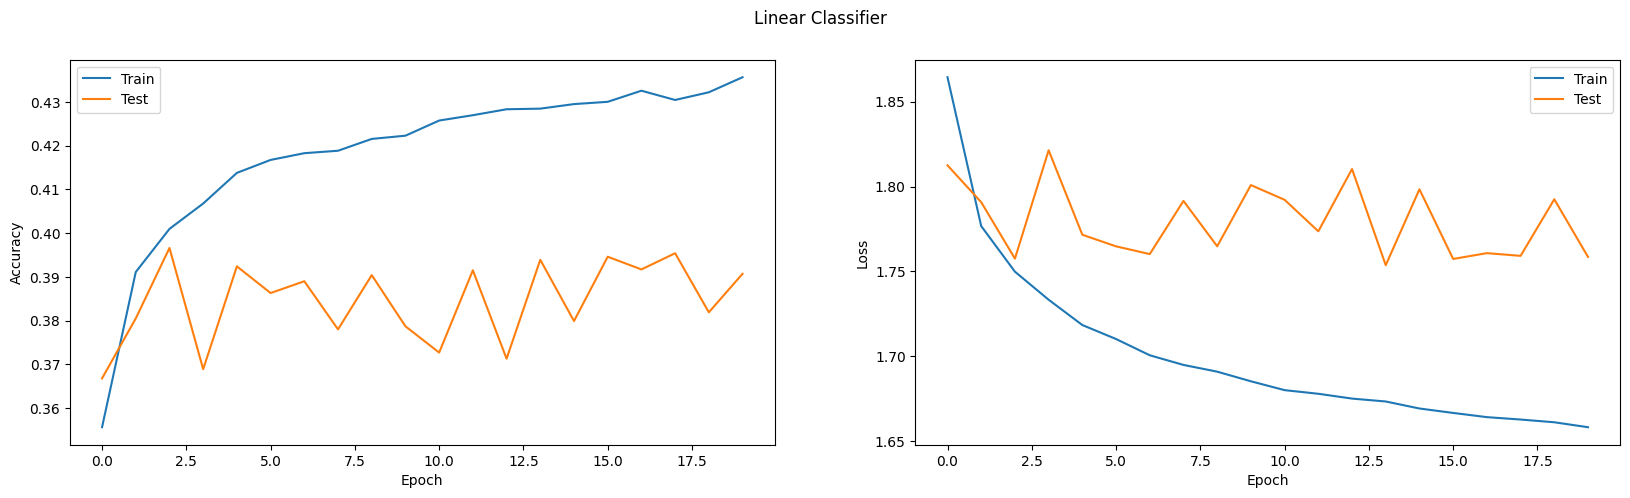

In [ ]:
plot_losses(train_losses_linear,
            test_losses_linear,
            train_accuracies_linear,
            test_accuracies_linear,
            "Linear Classifier")

We can also have a look at some predictions of our model of the test set. The function `plot_predictions(dataloader, model_name, class_name=None)` plots predictions of of random images of the test set with our model. The input data should be a dataloader. By specifying the optional parameter class_name, only correct predictions, false positives and false negatives of this class will be plotted. Feel free to change the parameters below. In the image below you can see an example output of the function with the `class_name='horse'` for a different model.
You can now also set the paramter "sort_prediction = True" to get images with the highest predictions.

![alt text](https://owncloud.tuwien.ac.at/index.php/apps/files_sharing/ajax/publicpreview.php?x=2193&y=855&a=true&file=horse_predictions.png&t=S2kIp8E9DGylCns&scalingup=0)


Number of correct recognized images: 3919
Number of wrong recognized images: 6081


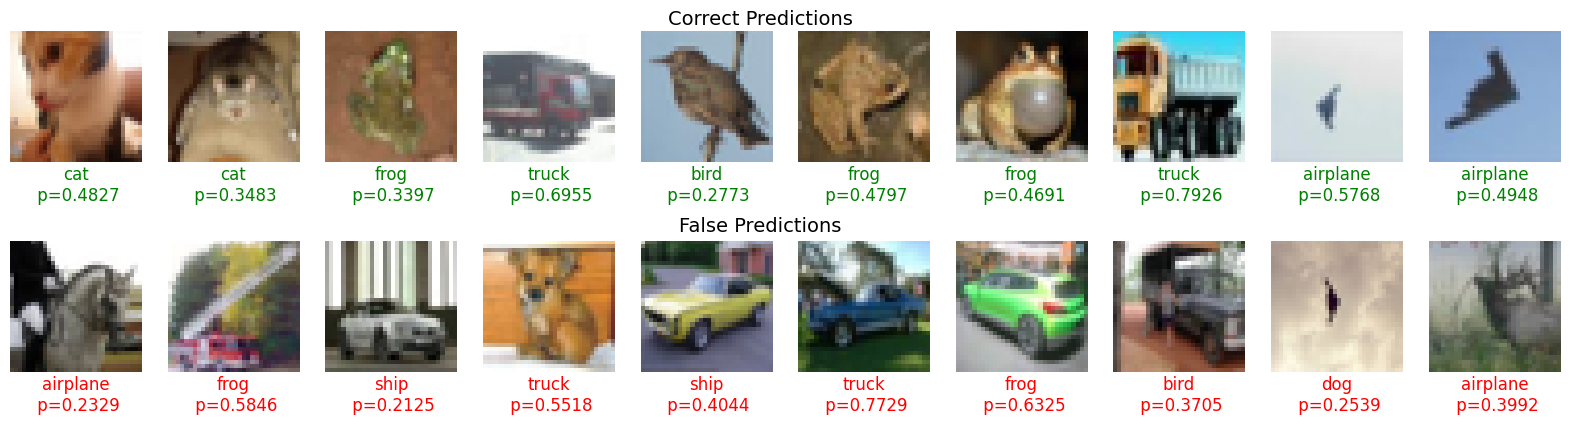

In [ ]:
plot_predictions(testloader, linear_model)

Number of correct recognized dog images is 236
Number of images recognized as dog but are not of that class is 455
Number of images not recognized as dog but actually are of that class is 764


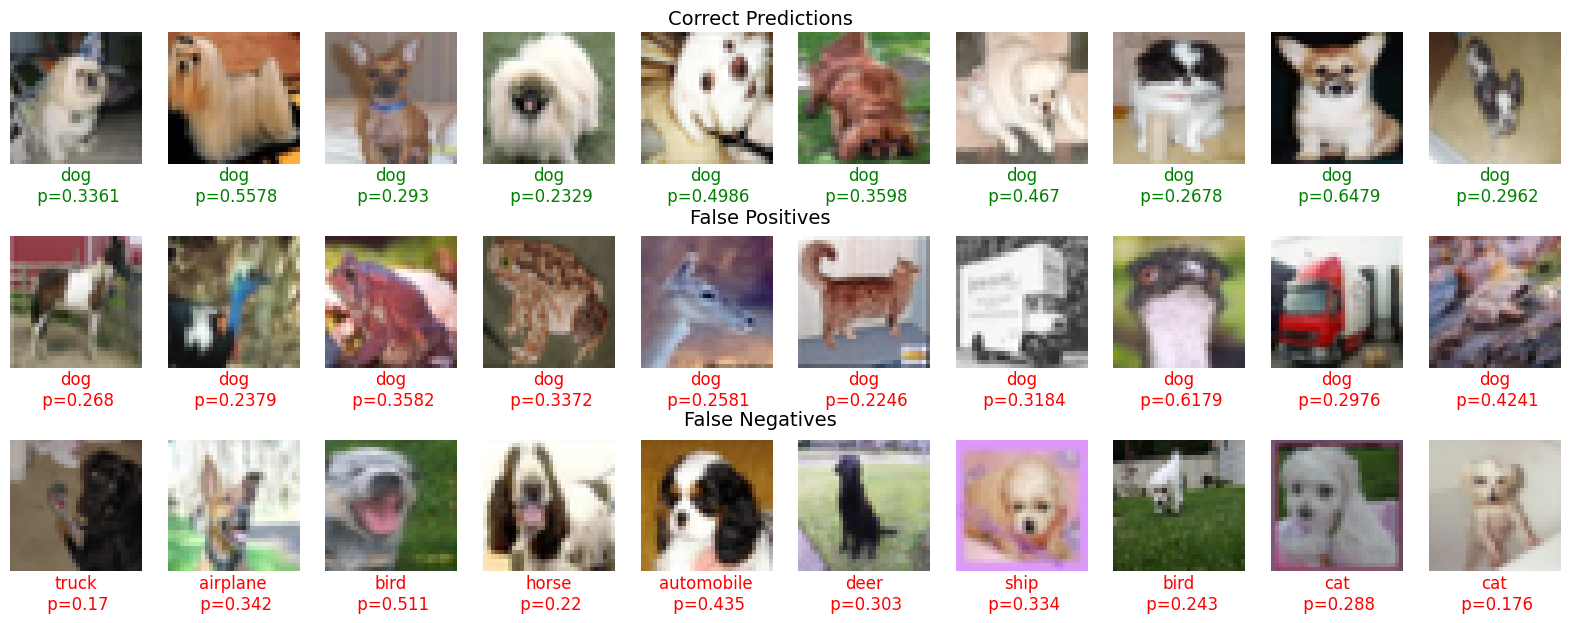

In [ ]:
plot_predictions(testloader, linear_model, class_name='dog')

##5. Multilayer Perceptron (1 Point)
The last model with only one layer reached appr. 30% of validation accuracy. It is already better than random guessing but not really satisfactory. Now it's time to add the "Deep" to Deep Learning. Create a model with multiple dense layers (a multilayer perceptron) with ReLu activation in the hidden layers and train it again for about 30 Epochs. The exact structure of the model is up to you, a good starting point is a layer with 256 units, followed by another layer with 128 units and followed by the output layer. This model should reach around 50% of validation accuracy. Training time is dependent on your model but should be below 20s per epoch.

In [ ]:
class MultiLayerPerceptron(nn.Module):
  def __init__(self, mean: Tuple, std: Tuple):
    super().__init__()
    ###################################
    # Convert mean and std to tensors and reshape for batch processing
    self.mean = torch.tensor(mean, dtype=torch.float).to(device)
    self.std = torch.tensor(std, dtype=torch.float).to(device)

    # Define input size
    input_size = 3 * 32 * 32
    num_classes = 10

    # Define the layers of the network
    self.fc1 = nn.Linear(input_size, 256)  # First fully-connected layer
    self.fc2 = nn.Linear(256, 128)         # Second fully-connected layer
    self.fc3 = nn.Linear(128, num_classes) # Output layer


    ###################################
  def forward(self, x):
    ###################################
    # Reshape mean and std to match the input dimensions
    mean = self.mean.view(1, -1, 1, 1)
    std = self.std.view(1, -1, 1, 1)

    # Normalize the input
    x = (x - mean) / std

    # Flatten the input for the linear layers
    x = x.view(x.size(0), -1)

    # Forward pass through the network
    x = F.relu(self.fc1(x))  # Apply ReLU activation after first layer
    x = F.relu(self.fc2(x))  # Apply ReLU activation after second layer
    x = self.fc3(x)          # Output layer
    ###################################
    return x

# Calculate mean and standard deviation to pass to the network
mean, std = calculate_mean_std(trainset)

# Initialize the model
mlp_model = MultiLayerPerceptron(mean=mean, std=std).to(device)


# Set the epochs and learning_rate parameters
epochs = 30
learning_rate = 0.01

# As an optimizer we use Stochastic Gradient Descent
optimizer_mlp = torch.optim.SGD(mlp_model.parameters(), lr=learning_rate)


loss_fn_mlp = nn.CrossEntropyLoss()

In [ ]:
# Actual Training

# Run the test_loop once to verify our model is not trained already
test_loop(testloader, mlp_model, loss_fn_mlp)

# Lists to log the losses during the training process
train_losses_mlp = []
train_accuracies_mlp = []

test_losses_mlp = []
test_accuracies_mlp = []

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loss, train_acc = train_loop(trainloader,
                                     mlp_model,
                                     loss_fn_mlp,
                                     optimizer_mlp)

  test_loss, test_acc = test_loop(testloader,
                                  mlp_model,
                                  loss_fn_mlp)

  train_losses_mlp.append(train_loss)
  train_accuracies_mlp.append(train_acc)

  test_losses_mlp.append(test_loss)
  test_accuracies_mlp.append(test_acc)
print("Done!")

Test Error: 
 Accuracy: 10.4%, Avg loss: 2.308657 

Epoch 1
-------------------------------
loss: 2.326638  [    0/50000]

loss: 2.151565  [12800/50000]

loss: 2.076434  [25600/50000]

loss: 1.900975  [38400/50000]

Test Error: 
 Accuracy: 35.5%, Avg loss: 1.846732 

Epoch 2
-------------------------------
loss: 1.842820  [    0/50000]

loss: 1.865927  [12800/50000]

loss: 1.739353  [25600/50000]

loss: 1.703855  [38400/50000]

Test Error: 
 Accuracy: 40.8%, Avg loss: 1.693781 

Epoch 3
-------------------------------
loss: 1.694595  [    0/50000]

loss: 1.674431  [12800/50000]

loss: 1.556185  [25600/50000]

loss: 1.690093  [38400/50000]

Test Error: 
 Accuracy: 43.3%, Avg loss: 1.613563 

Epoch 4
-------------------------------
loss: 1.635902  [    0/50000]

loss: 1.596045  [12800/50000]

loss: 1.517807  [25600/50000]

loss: 1.602654  [38400/50000]

Test Error: 
 Accuracy: 45.4%, Avg loss: 1.557988 

Epoch 5
-------------------------------
loss: 1.632599  [    0/50000]

loss: 1.58644

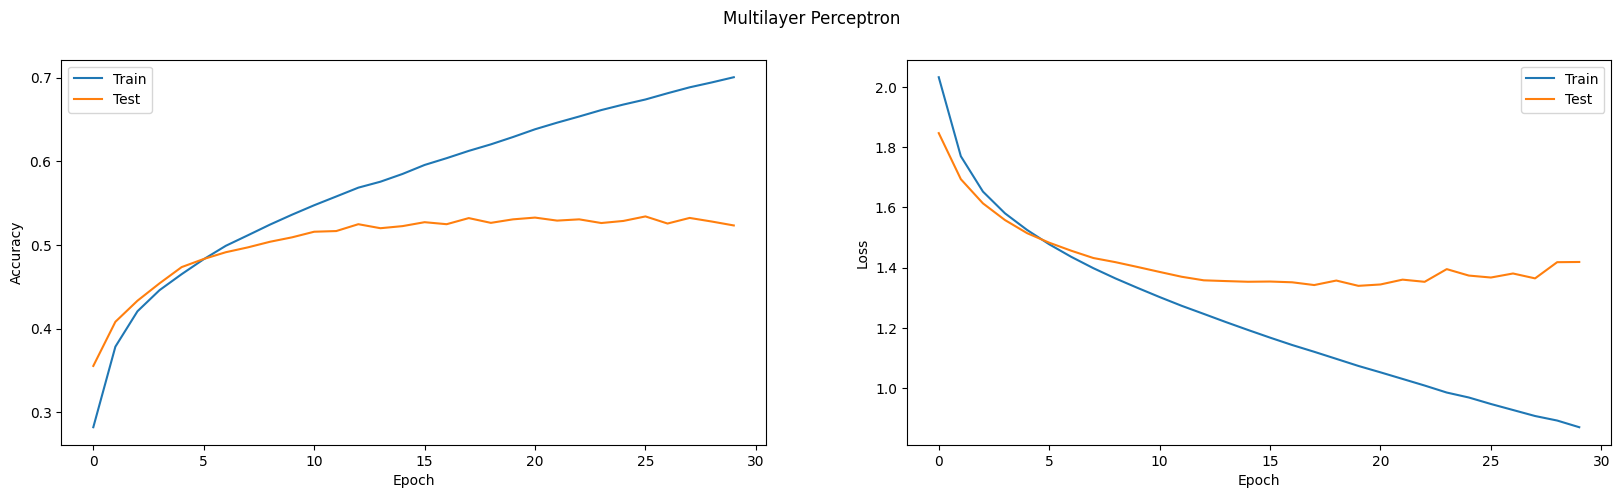

In [ ]:
plot_losses(train_losses_mlp,
            test_losses_mlp,
            train_accuracies_mlp,
            test_accuracies_mlp,
            "Multilayer Perceptron")

## 6. MLP with Regularization (1 Point)
To counter the problem of overfitting, you should add measures for regularization. Create a new model based on your MLP from the last point which includes at least one regularization technique. It should improve the validation accuracy slightly.

In [ ]:
class MultiLayerPerceptronRegularization(nn.Module):
  def __init__(self, mean: Tuple, std: Tuple):
    super().__init__()
    ###################################
    # Convert mean and std to tensors and reshape for batch processing
    self.mean = torch.tensor(mean, dtype=torch.float).to(device)
    self.std = torch.tensor(std, dtype=torch.float).to(device)

    # Define input size and number of classes
    input_size = 3 * 32 * 32
    num_classes = 10

    # Define the layers of the network
    self.fc1 = nn.Linear(input_size, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, num_classes)

    # Define Dropout layer
    self.dropout = nn.Dropout(0.5)

    ###################################
  def forward(self, x):
    ###################################
    # Reshape mean and std to match the input dimensions
    mean = self.mean.view(1, -1, 1, 1)
    std = self.std.view(1, -1, 1, 1)

    # Normalize the input
    x = (x - mean) / std

    # Flatten the input
    x = x.view(x.size(0), -1)

    # Forward pass through the network with ReLU and Dropout
    x = F.relu(self.fc1(x))
    x = self.dropout(x)  # Apply dropout after the first hidden layer
    x = F.relu(self.fc2(x))
    x = self.dropout(x)  # Apply dropout after the second hidden layer
    x = self.fc3(x)

    ###################################
    return x

# Calculate mean and standard deviation to pass to the network
mean, std = calculate_mean_std(trainset)

# Initialize model
mlp_model_reg = MultiLayerPerceptronRegularization(mean=mean, std=std).to(device)

# Set the epochs and learning_rate parameters
epochs = 30
learning_rate = 0.01

# Set up the optimizer with L2 regularization (weight decay)
weight_decay = 1e-4


In [ ]:
# Actual Training

# Define the loss function
loss_fn_mlp_reg = nn.CrossEntropyLoss()

# As an optimizer we use Stochastic Gradient Descent
optimizer_mlp_reg = torch.optim.SGD(mlp_model_reg.parameters(),
                                    lr=learning_rate, weight_decay=weight_decay) # Set up the optimizer with L2 regularization (weight decay)

# Run the test_loop once to verify our model is not trained already
test_loop(testloader, mlp_model_reg, loss_fn_mlp_reg)

# Lists to log the losses during the training process
train_losses_mlp_reg = []
train_accuracies_mlp_reg = []

test_losses_mlp_reg = []
test_accuracies_mlp_reg = []

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loss, train_acc = train_loop(trainloader,
                                     mlp_model_reg,
                                     loss_fn_mlp_reg,
                                     optimizer_mlp_reg)
  test_loss, test_acc = test_loop(testloader,
                                  mlp_model_reg,
                                  loss_fn_mlp_reg)

  train_losses_mlp_reg.append(train_loss)
  train_accuracies_mlp_reg.append(train_acc)

  test_losses_mlp_reg.append(test_loss)
  test_accuracies_mlp_reg.append(test_acc)
print("Done!")

Test Error: 
 Accuracy: 10.8%, Avg loss: 2.318935 

Epoch 1
-------------------------------
loss: 2.295380  [    0/50000]

loss: 2.196274  [12800/50000]

loss: 2.049639  [25600/50000]

loss: 2.146065  [38400/50000]

Test Error: 
 Accuracy: 29.8%, Avg loss: 1.960472 

Epoch 2
-------------------------------
loss: 1.948055  [    0/50000]

loss: 1.912738  [12800/50000]

loss: 2.059098  [25600/50000]

loss: 1.963807  [38400/50000]

Test Error: 
 Accuracy: 33.1%, Avg loss: 1.860150 

Epoch 3
-------------------------------
loss: 1.763052  [    0/50000]

loss: 1.776192  [12800/50000]

loss: 1.750823  [25600/50000]

loss: 1.659202  [38400/50000]

Test Error: 
 Accuracy: 35.9%, Avg loss: 1.803010 

Epoch 4
-------------------------------
loss: 1.782664  [    0/50000]

loss: 1.753874  [12800/50000]

loss: 1.722879  [25600/50000]

loss: 1.617937  [38400/50000]

Test Error: 
 Accuracy: 37.2%, Avg loss: 1.765112 

Epoch 5
-------------------------------
loss: 1.851254  [    0/50000]

loss: 1.71482

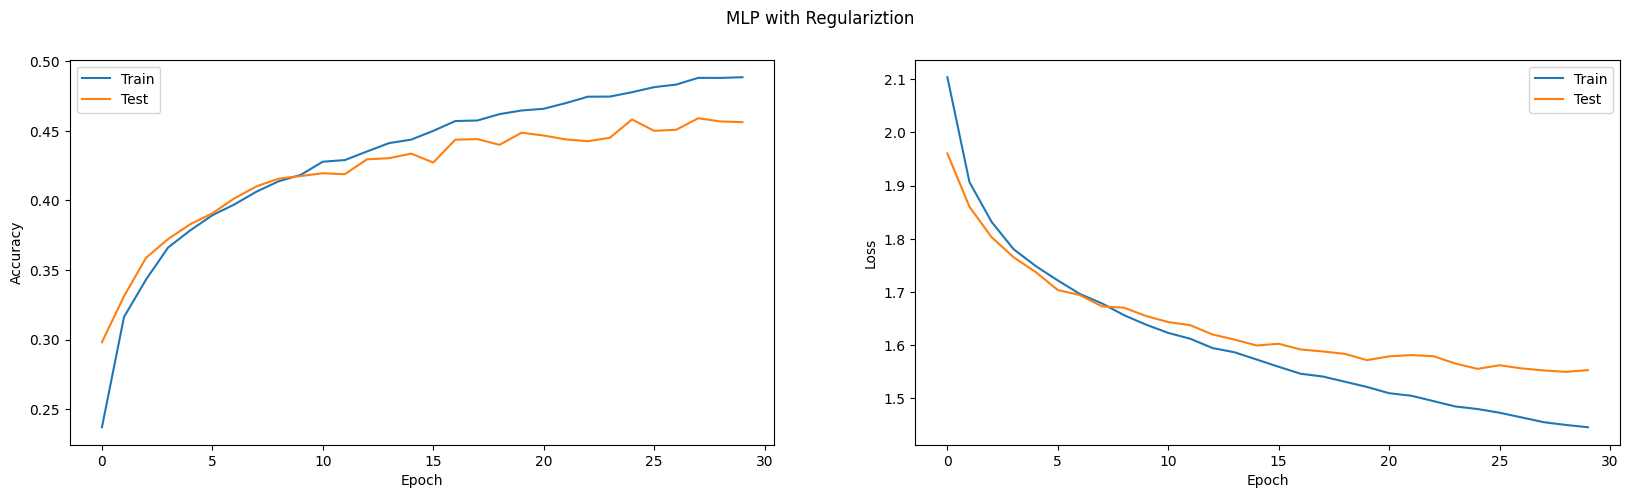

In [ ]:
plot_losses(train_losses_mlp_reg,
            test_losses_mlp_reg,
            train_accuracies_mlp_reg,
            test_accuracies_mlp_reg,
            "MLP with Regulariztion")

Number of correct recognized bird images is 322
Number of images recognized as bird but are not of that class is 467
Number of images not recognized as bird but actually are of that class is 678


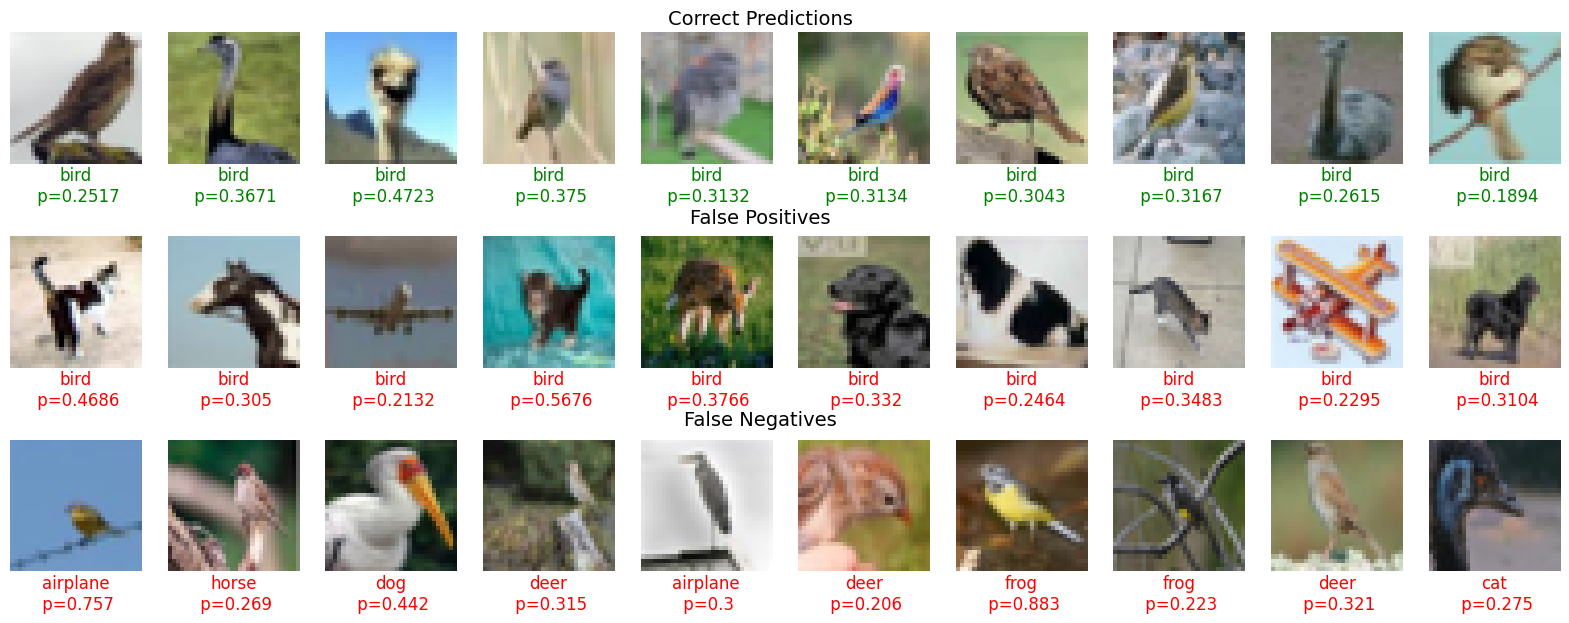

In [ ]:
plot_predictions(testloader, mlp_model_reg, class_name='bird')

## 7. Convolutional Neural Network (2 Point)
When converting our images to vectors, all spatial information is lost. A convolutional neural network takes tensors as input and computes features that make use of spatial information. In this exercise implement a neural network as specified in the image below. Add regularization techniques until you reach at least 75% of validation accuracy with a training time of below 30s per epoch.

Notes: 3x3 Conv X refers to a Conv2D layer with kernel 3x3 and X units.
Maxpool /2 refers to a MaxPool layer with kernel=(2,2) and stride=2.


![Network Architecture](https://owncloud.tuwien.ac.at/index.php/apps/files_sharing/ajax/publicpreview.php?x=1747&y=643&a=true&file=ex4_cnn_architecture.png&t=UpMwi8LlXvwKJ2e&scalingup=0)

Figure 3: Network Architecture

---

In [11]:
class CNNClassifier(nn.Module):
  def __init__(self, mean: Tuple, std: Tuple):
    super().__init__()
    ###################################
    self.mean = torch.tensor(mean, dtype=torch.float).to(device)
    self.std = torch.tensor(std, dtype=torch.float).to(device)

    # Convolutional layers
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

    # Pooling layers
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

    # Fully connected layers
    self.fc = nn.Linear(128, 256)

    # Output layer
    self.output = nn.Linear(256, 10)

    # Regularization: Dropout
    self.dropout = nn.Dropout(0.5)

    ###################################
  def forward(self, x):
    ###################################
    # Reshape mean and std to match the input dimensions
    mean = self.mean.view(1, -1, 1, 1)
    std = self.std.view(1, -1, 1, 1)

    # Normalize
    x = (x - mean) / std

    # Convolutional layers with activations and pooling
    x = F.relu(self.conv1(x))
    x = self.pool(x)

    x = F.relu(self.conv2(x))
    x = self.pool(x)

    x = F.relu(self.conv3(x))

    # Global average pooling
    x = self.global_avg_pool(x)
    x = x.view(x.size(0), -1)

    # Fully connected layer with Dropout
    x = self.dropout(F.relu(self.fc(x)))

    # Output layer
    x = self.output(x)

    ###################################
    return x

# Calculate mean and standard deviation to pass to the network
mean, std = calculate_mean_std(trainset)

# Initialize the model
cnn_model = CNNClassifier(mean=mean, std=std).to(device)

# Set the number of epochs and learing_rate
epochs = 30
learning_rate = 0.001

# As an optimizer we use Adam
optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)



In [12]:
# Actual Training

# Define the loss function
loss_fn_cnn = nn.CrossEntropyLoss()

# Run the test_loop once to verify our model is not trained already
test_loop(testloader,
          cnn_model,
          loss_fn_cnn)

# Lists to log the losses during the training process
train_losses_cnn = []
train_accuracies_cnn = []

test_losses_cnn = []
test_accuracies_cnn = []

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loss, train_acc = train_loop(trainloader,
                                     cnn_model,
                                     loss_fn_cnn,
                                     optimizer_cnn)
  test_loss, test_acc = test_loop(testloader,
                                  cnn_model,
                                  loss_fn_cnn)

  train_losses_cnn.append(train_loss)
  train_accuracies_cnn.append(train_acc)

  test_losses_cnn.append(test_loss)
  test_accuracies_cnn.append(test_acc)
print("Done!")

Test Error: 
 Accuracy: 10.5%, Avg loss: 2.304254 

Epoch 1
-------------------------------
loss: 2.307733  [    0/50000]

loss: 1.743922  [12800/50000]

loss: 1.560197  [25600/50000]

loss: 1.669605  [38400/50000]

Test Error: 
 Accuracy: 39.3%, Avg loss: 1.626402 

Epoch 2
-------------------------------
loss: 1.713345  [    0/50000]

loss: 1.506209  [12800/50000]

loss: 1.494627  [25600/50000]

loss: 1.462583  [38400/50000]

Test Error: 
 Accuracy: 48.0%, Avg loss: 1.406949 

Epoch 3
-------------------------------
loss: 1.439512  [    0/50000]

loss: 1.473748  [12800/50000]

loss: 1.250179  [25600/50000]

loss: 1.285806  [38400/50000]

Test Error: 
 Accuracy: 53.8%, Avg loss: 1.283290 

Epoch 4
-------------------------------
loss: 1.087006  [    0/50000]

loss: 1.142008  [12800/50000]

loss: 1.184240  [25600/50000]

loss: 1.072688  [38400/50000]

Test Error: 
 Accuracy: 57.3%, Avg loss: 1.182032 

Epoch 5
-------------------------------
loss: 1.135606  [    0/50000]

loss: 1.07432

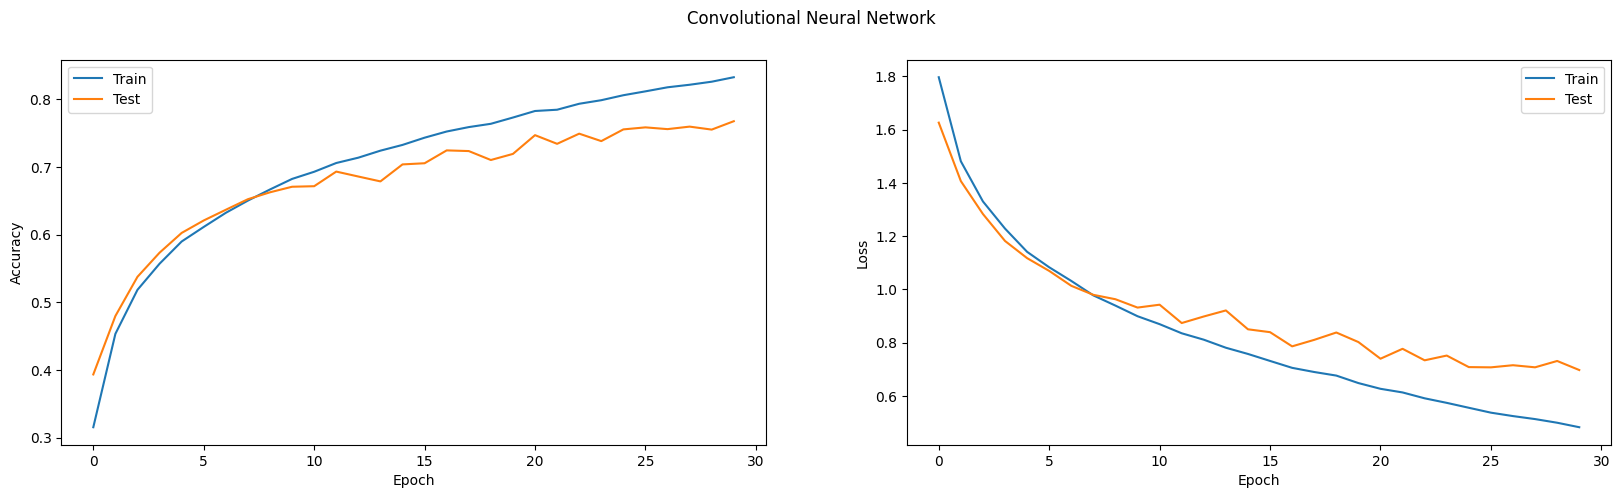

In [13]:
plot_losses(train_losses_cnn,
            test_losses_cnn,
            train_accuracies_cnn,
            test_accuracies_cnn,
            "Convolutional Neural Network")

Number of correct recognized dog images is 686
Number of images recognized as dog but are not of that class is 280
Number of images not recognized as dog but actually are of that class is 314


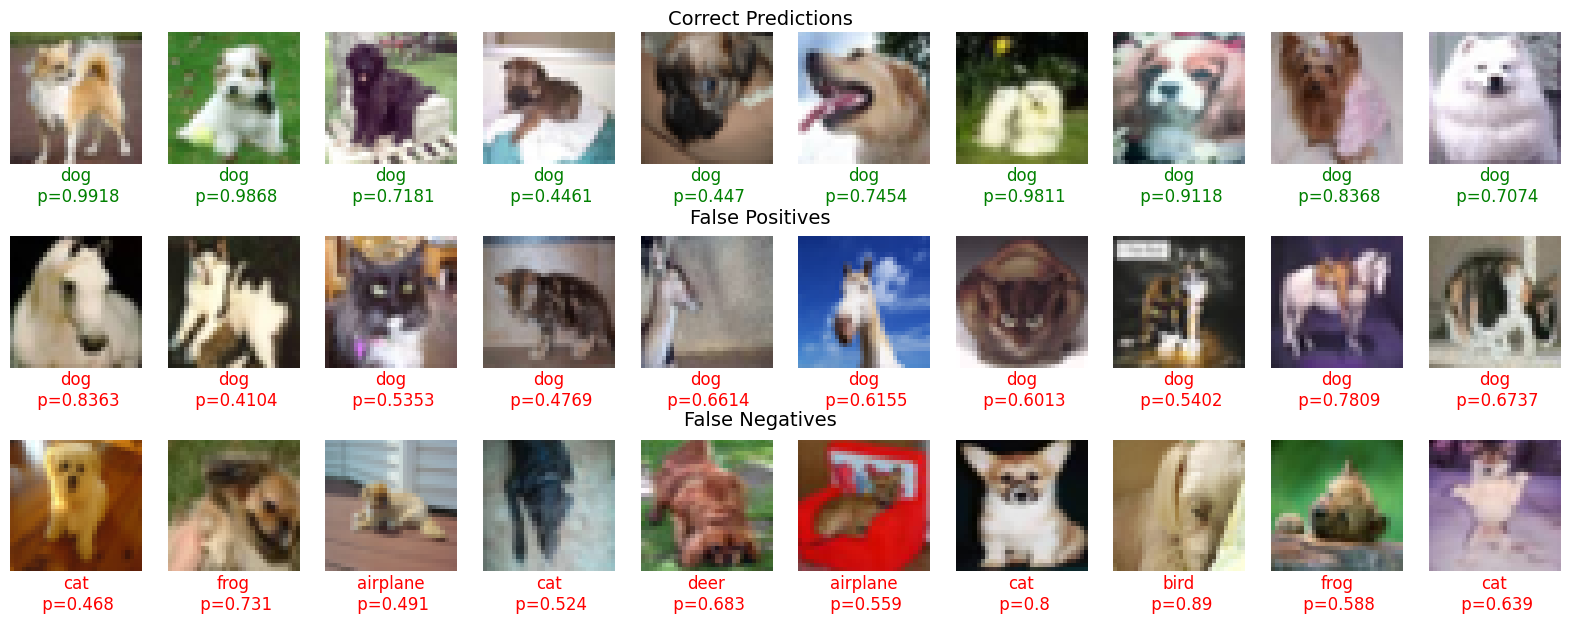

In [14]:
plot_predictions(testloader, cnn_model, class_name='dog')

## 8. Transfer Learning (2 Point)
In the next step we want to use a model which is already pre-trained on a large dataset (Imagenet) and finetune it for the CIFAR10 dataset. PyTorch already provides us with multiple pretrained models (see https://pytorch.org/vision/stable/models.html). Your task is to take the ResNet50 model and **only** retrain the last layer. You should upsample the images first because ResNet is trained on Images with the resolution of (224, 224). Training with this resolution takes a substantial amount of time with not that much gain. A resolution of (128, 128) is a good compromise between accuracy and training time. You can use the `Resize` transform from `pytorch.transforms`. You should also normalize the images the same way as ResNet does. This approach should get you to over 80% of validation accuracy. Training time will take much longer here (~120 seconds per epoch), so you only need to train for 5-10 epochs. We won't provide a template for this part again, just add the code for loading the model,  exchanging the last layer and training it in the cell below.

In [ ]:
from torchvision import models
###################################
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Reference to the below code (https://harinramesh.medium.com/transfer-learning-in-pytorch-f7736598b1ed)

# Define transformations with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(128, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the image transformations including resizing to 128x128 and normalization
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the images to 128x128
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply the transforms and load the CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=128,
                                          shuffle=True,
                                          pin_memory = True,
                                          num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1024,
                                         shuffle=False,
                                         pin_memory = True,
                                         num_workers=2)


# Load the pre-trained ResNet50 model
resnet50 = models.resnet50(pretrained=True)

# Freeze all the layers except for the final layer
for param in resnet50.parameters():
    param.requires_grad = False

# Replace the last fully connected layer to match the number of classes in CIFAR10
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 10)

# Move the model to the chosen device
resnet50 = resnet50.to(device)

# Define the optimizer and loss function
optimizer = optim.SGD(resnet50.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

# Lists to log the losses during the training process
train_losses_resnet = []
train_accuracies_resnet = []
test_losses_resnet = []
test_accuracies_resnet = []

# Initialize the number of epochs
epochs = 5

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  resnet50.train()  # Set the model to training mode
  train_loss, train_acc = train_loop(trainloader, resnet50, loss_fn, optimizer)

  resnet50.eval()  # Set the model to evaluation mode
  test_loss, test_acc = test_loop(testloader, resnet50, loss_fn)

  # Log the metrics
  train_losses_resnet.append(train_loss)
  train_accuracies_resnet.append(train_acc)
  test_losses_resnet.append(test_loss)
  test_accuracies_resnet.append(test_acc)

print("Done!")

###################################



Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 146MB/s]


Epoch 1
-------------------------------
loss: 2.292925  [    0/50000]

loss: 3.010996  [12800/50000]

loss: 1.357710  [25600/50000]

loss: 1.329620  [38400/50000]

Test Error: 
 Accuracy: 75.4%, Avg loss: 1.646587 

Epoch 2
-------------------------------
loss: 1.674259  [    0/50000]

loss: 2.213290  [12800/50000]

loss: 1.373160  [25600/50000]

loss: 1.230746  [38400/50000]

Test Error: 
 Accuracy: 75.8%, Avg loss: 1.961255 

Epoch 3
-------------------------------
loss: 1.624849  [    0/50000]

loss: 1.319296  [12800/50000]

loss: 1.099874  [25600/50000]

loss: 2.616366  [38400/50000]

Test Error: 
 Accuracy: 77.2%, Avg loss: 1.373638 

Epoch 4
-------------------------------
loss: 1.598652  [    0/50000]

loss: 2.284317  [12800/50000]

loss: 1.229346  [25600/50000]

loss: 2.239033  [38400/50000]

Test Error: 
 Accuracy: 78.0%, Avg loss: 1.392344 

Epoch 5
-------------------------------
loss: 1.273889  [    0/50000]

loss: 1.280346  [12800/50000]

loss: 2.420465  [25600/50000]

los

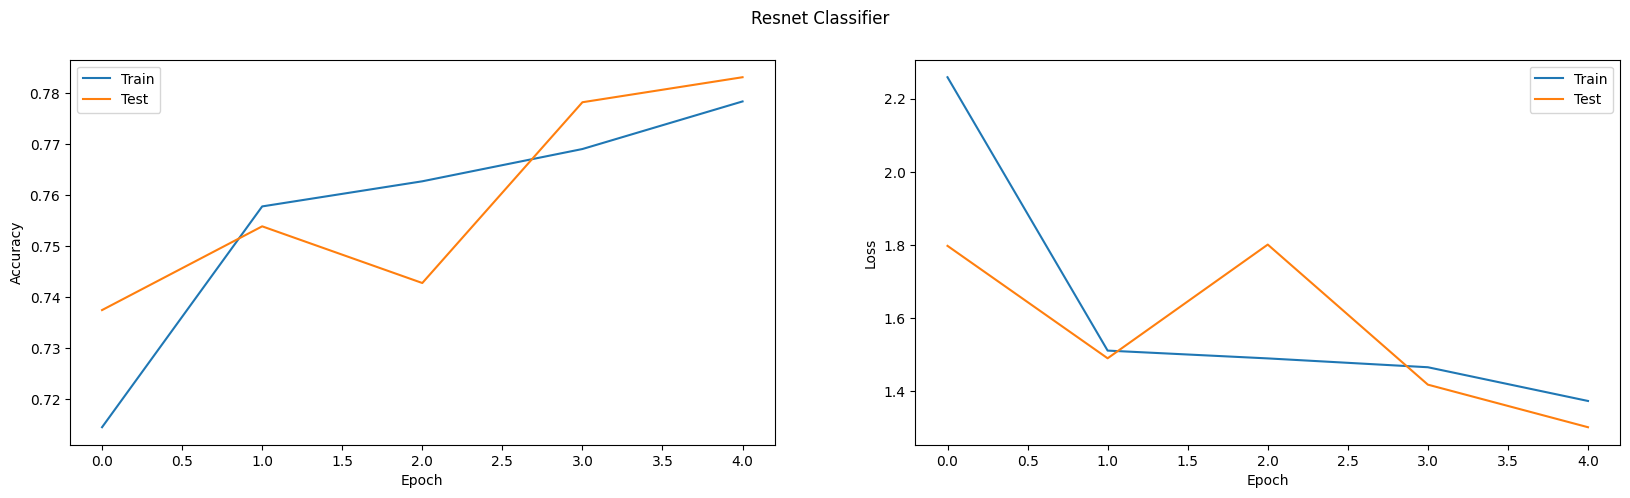

In [ ]:
plot_losses(train_losses_resnet,
            test_losses_resnet,
            train_accuracies_resnet,
            test_accuracies_resnet,
            "Resnet Classifier")

# Experiments
Here you can add code that you need for your documentation. Feel free to play around in this section with the models, your own images, create new models, data augmentation, different datasets, ...



<ipython-input-7-a900fb10715a>:359: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im_from_link = Image.fromarray(imageio.imread((response.content)))
<ipython-input-7-a900fb10715a>:363: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  loaded_image = im_from_link.resize((width, height), Image.ANTIALIAS)


Top-5 Predictions:

  Bird - 99.9 %

  Deer - 0.06 %

  Frog - 0.04 %

  Dog - 0.0 %

  Cat - 0.0 %
torch.Size([1, 3, 32, 32])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


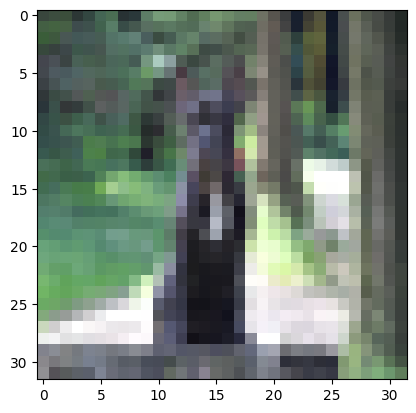

In [ ]:
# Load an image from that link and get Top-5 predictions
test_im = load_image_link('https://pixy.org/src2/685/6857786.jpg')
plt.imshow(test_im[0,...])

#vec_im = vectorize_images(test_im)
predict_image(resnet50, test_im, transform=transforms.ToTensor())

labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
# prediction with a model
img_torch = torch.from_numpy(np.transpose(test_im.astype(np.float32), (0,3,1,2))/255.)
print(img_torch.shape)
plt.imshow(transforms.ToPILImage()(img_torch[0]))


In [ ]:
# If you want to mount your Google Drive to store weights or plots for example
# you can use the commands below. Check this link for more information:
# https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
